In [1]:
import os
import glob
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf
import io
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1738372676.999782   85385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738372677.012678   85385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [60]:
H=512 # height
W=512 # width  
C=3 # channels
h=4 # heads

P=16 # patch size
assert(H == W)
assert(H%P == 0)

D_model : int =512 # transformer latent dim
D_head : int  = D_model//h #dim of each head
D_fcn : int =2048 # FCN hidden dim
num_layers: int =4 # transformer depth
BS: int =4 # batch size
N: int =(H*W)//(P*P) # Number of patches

In [3]:
FLOAT=tf.float16

In [4]:
def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant((H,W,C))))
    
    return img, is_valid

dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 50


all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(lambda img, is_valid: is_valid)  # Keep valid images
dataset = dataset.map(lambda img, is_valid: img) # remove unused feature
dataset = dataset.map(lambda img: tf.ensure_shape(img, (H, W, C)))
print(f"Total files: {len(selected_files)}")
valid_count = dataset.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
print(f"Valid images count: {valid_count}")
assert(valid_count), "Everything's gone"

I0000 00:00:1738372682.884678   85385 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Total files: 50
Valid images count: 50


In [5]:
def visualize_unbatched_dataset(dataset: tf.data.Dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, (image) in enumerate(dataset.take(num_images)):  # Extract each sample
        ax = axes[i] if num_images > 1 else axes
        image = tf.cast(image,dtype=tf.float32)
        ax.imshow(image.numpy().squeeze(), cmap='gray')  # Adjust based on dataset shape
        ax.axis("off")
    
    plt.show()


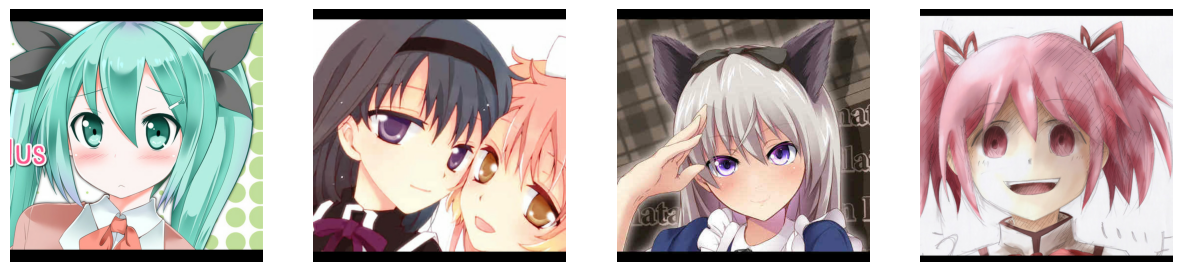

In [61]:
visualize_unbatched_dataset(dataset, 4)

In [71]:
def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H-100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 100, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 100, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)
    
    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack([tf.repeat(tf.range(y1, y2), x2 - x1), tf.tile(tf.range(x1, x2), [y2 - y1])], axis=-1),
        updates=tf.zeros([ (y2 - y1) * (x2 - x1) ], dtype=tf.bool)
    )
    return mask

def mask_area(mask):
    return tf.reduce_sum(tf.cast(tf.logical_not(mask), tf.float32)) 

def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

def visualize_mask_on_image(image, mask):
    tf.print(mask_area(mask))

    # Ensure both image and mask are in float32 format
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    mask_expanded = tf.expand_dims(mask, axis=-1)
    masked_image = tf.multiply(image, mask_expanded)

    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(image.numpy() , cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Plot masked image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(masked_image.numpy(), cmap='gray')
    plt.title("Masked Image")
    plt.axis("off")

    # Show both plots
    plt.tight_layout()
    plt.show()


def extract_patches(image: tf.Tensor) -> tf.Tensor:
    # R^{BS x H x W x C} -> R^{BS x N x P^2 x C}
    patches : tf.Tensor = tf.image.extract_patches(
        images=image,  # Add batch dim
        sizes=[1, P, P, 1],  # Patch size
        strides=[1, P, P, 1],  # Step size
        rates=[1, 1, 1, 1],  # No dilation
        padding='VALID'
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))
    
    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])
    
    return patches

def process_mask(mask: tf.Tensor):
    # R^{BS x H x W} -> tuple[R^{BS x N}, R^{BS x N x N}]
    # viz_mask(mask)
    mask = tf.expand_dims(mask, axis=-1)  #  add channel dimension
    mask_pooled = tf.nn.max_pool2d(
            tf.cast(tf.logical_not(mask), dtype=tf.int8), #insane shit happaned here with mask_inverted
            ksize=[P, P],
            strides=[P, P],
            padding='VALID'
        )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled,tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])  
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=tf.float32),  # Use float32 for valid positions
        tf.constant(-float("inf"), dtype=tf.float32)  # -inf for invalid
    )
    # tf.print(tf.shape(A))
    
    return mask_pooled, A


class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.proj = keras.layers.Dense(D_model)  # (P² * C) -> D_model
        self.positional_embedding = self.add_weight(
            shape=(1, N, D_model),
            initializer="random_normal",
            trainable=True,
            name="positional_embedding"
        )
        
    # def build(self, input_shape):
    #     self.call(tf.zeros((BS, N , P**2 * C)))
    #     self.built = True

    def call(self, patches_flat: tf.Tensor):
        # R^{N x (P^2 . C)} -> R^{N x D_model}
        X = self.proj(patches_flat)  # (N, D_model)
        X += self.positional_embedding  # (N, D_model)
        return X

    

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.W_Q = keras.layers.Dense(D_model)
        self.W_K = keras.layers.Dense(D_model)
        self.W_V = keras.layers.Dense(D_model)
        self.W_O = keras.layers.Dense(D_model)

    def call(self, X, A):
        
        # X \in R^{BS x N x D_model} 
        # A \in R^{BS x N x N}
        
        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.  
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS , N, D_model)
        K = self.W_K(X)  # (BS , N, D_model)
        V = self.W_V(X)  # (BS , N, D_model)
        
        Q = tf.reshape(Q, (-1, N, h, D_head))
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (4, 4, 1024, 128)
        K = tf.reshape(K, (-1, N, h, D_head))
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.reshape(V, (-1, N, h, D_head))
        V = tf.transpose(V, [0, 2, 1, 3])

        # Compute scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (4, 4, 1024, 1024)
        attn_scores /= tf.math.sqrt(tf.cast(D_head, attn_scores.dtype))  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # Expand dim for broadcasting: (4, 1, 1024, 1024)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (4, 4, 1024, 1024)

        output = tf.matmul(attn_weights, V)  # (4, 4, 1024, 128)

        output = tf.transpose(output, [0, 2, 1, 3])  # (4, 1024, 4, 128)
        combined = tf.reshape(output, (-1, N, D_model))  # (4, 1024, 512)

        return self.W_O(combined)  # (4, 1024, 512)

class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization()
        self.norm2 = keras.layers.LayerNormalization()
        self.ffn = keras.Sequential([
            keras.layers.Dense(D_fcn, activation="gelu"),
            keras.layers.Dense(D_model),
            keras.layers.Dropout(0.1)
        ])

    def call(self, X, A):
        X = self.norm1(X + self.attn(X, A))
        X = self.norm2(X + self.ffn(X))
        return X

class Decoder(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.proj = keras.layers.Dense(P * P * C)

    def call(self, X):
        X = self.proj(X)  # (N, P^2 * C)
        X = tf.reshape(X, (-1, P, P, C))  # (N, P, P, C)
        return X

class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = Decoder()

    def build(self):
        dummy_images = tf.zeros((BS,H,W,C))
        dummy_masks = tf.stack([random_visibility_mask() for _ in range(BS)])
        self.call(dummy_images, dummy_masks)
        self.built = True
    
    def call(self, image, mask):
        patches = extract_patches(image)
        mask_pooled, A = process_mask(mask)
        # tf.print(tf.shape(mask_pooled))
        # tf.print(tf.shape(A))
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        
        X = self.embed(patches_flat)

        for block in self.transformer_blocks:
            X = block(X, A)

        reconstructed_patches = self.decoder(X)
        return reconstructed_patches

def l1_masked_loss(y_true, y_pred, mask):
    visible_region = tf.cast(tf.logical_not(mask), tf.float32)
    loss = tf.reduce_sum(tf.abs(visible_region * (y_pred - y_true)), axis=[1, 2, 3])

    normalizer = tf.reduce_sum(visible_region, axis=[1, 2, 3]) + 1e-6  # Avoid division by zero
    return tf.reduce_mean(loss / normalizer)



# mask = random_visibility_mask()
# viz_mask(mask)

model = ImageInpaintingTransformer()
model.build()
model.summary()
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: l1_masked_loss(y_true, y_pred, mask))

# img = next(iter(dataset.take(1)))
# visualize_mask_on_image(img,mask)

# tf.print(mask)

# image = tf.random.normal((2, 512, 512, 3))


Model: "image_inpainting_transformer_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding_60              │ ?                      │       918,016 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_236           │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_237           │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_238           │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_239           │ ?                      │     3,152,384 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_59 (Decoder)            │ ?                      │       393,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,921,536 (53.11 MB)

 Trainable params: 13,921,536 (53.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 100
steps_per_epoch = 1000  # Number of batches to train on per epoch

for epoch in range(epochs):
    for step, (img, mask) in enumerate(dataset):
        # Generate patches and attention mask
        patches = extract_patches(img)
        mask_pooled, A = process_mask(mask)
        
        # Reshape patches
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        
        # Forward pass
        with tf.GradientTape() as tape:
            reconstructed = model(img, mask)
            loss = loss_fn(img, reconstructed)
        
        # Backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Print progress
        if step % 10 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.numpy():.4f}")
    
    # Validate periodically
    if epoch % 10 == 0:
        val_loss = model.evaluate(val_dataset)
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")